# MNIST

### Importation 

In [1]:
import pandas as pd 
import numpy as np 
import librosa 
import librosa.display
import zipfile 
import tensorflow as tf
import sklearn 
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import requests
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
sns.set_style("dark")

In [3]:
file='data.zip'
zip_ref=zipfile.ZipFile(file,'r')
zip_ref.extractall("data")

In [4]:
All=glob('data/data/*/*.wav')

In [5]:
paths=[]
number=[]
for i in All :
    paths.append(i)
    part=i.split('\\')[2]
    part=part.split('_')[0]
    number.append(part)
df=pd.DataFrame(number,columns=["Number"])
df['Path']=pd.DataFrame(paths)
mapping={'0':'zero','1':'one','2':'two','3':'three','4':'four','5':'five','6':'six','7':'seven','8':'eight','9':'nine'}
df['number']=df['Number'].map(mapping)
df=df.drop(labels='Number',axis=1)
df['path']=pd.DataFrame(df.Path)
df.drop(labels='Path',axis=1,inplace=True)
df.tail()

,number,path
29995,nine,data/data\60\9_60_5.wav
29996,nine,data/data\60\9_60_6.wav
29997,nine,data/data\60\9_60_7.wav
29998,nine,data/data\60\9_60_8.wav
29999,nine,data/data\60\9_60_9.wav


### Visualization

In [6]:
def create_waveplot(path):
    data,sr=librosa.load(path)
    plt.figure(figsize=(14,3))
    plt.title('WavePlot')
    librosa.display.waveshow(data,sr=sr)
    plt.show()
def create_spectragram(path):
    data,sr=librosa.load(path)
    Forier=librosa.stft(data)
    db=librosa.amplitude_to_db(abs(Forier))
    plt.figure(figsize=(14,7))
    plt.title('Spectragram')
    librosa.display.specshow(db,
                            x_axis='time',
                            y_axis='log')
    plt.colorbar(format=f'%0.2f')
    plt.show()
def create_trimmed(path,db):
    data,sr=librosa.load(path)
    data_trimmed,_=librosa.effects.trim(data,top_db=db)
    pd.Series(data_trimmed[1000:1299]).plot(figsize=(14,3),lw=2,title='Raw Audio Trimmed')
    plt.show()

In [7]:
def visulizing(path):
    create_waveplot(path)
    create_trimmed(path,20)
    create_spectragram(path)
    display(ipd.Audio(path))


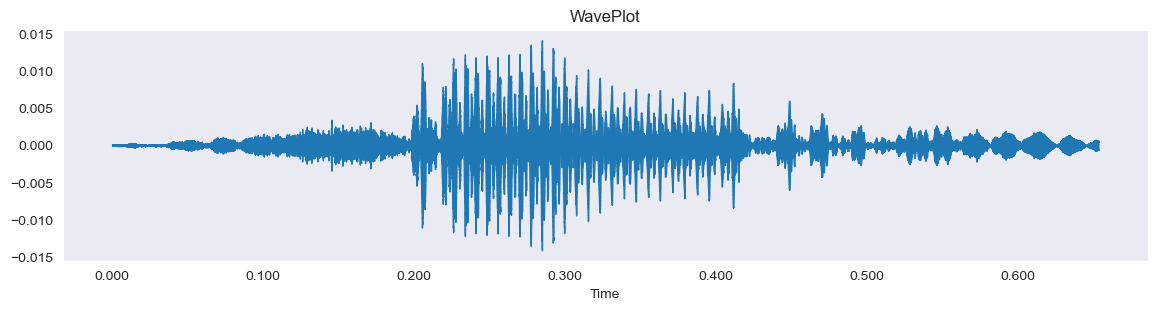

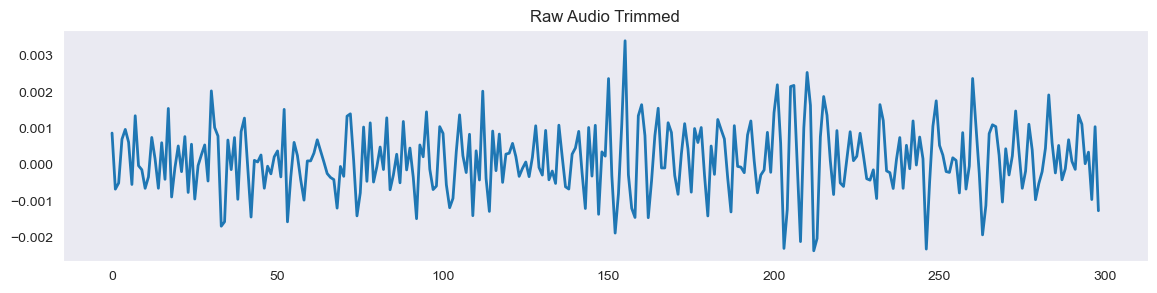

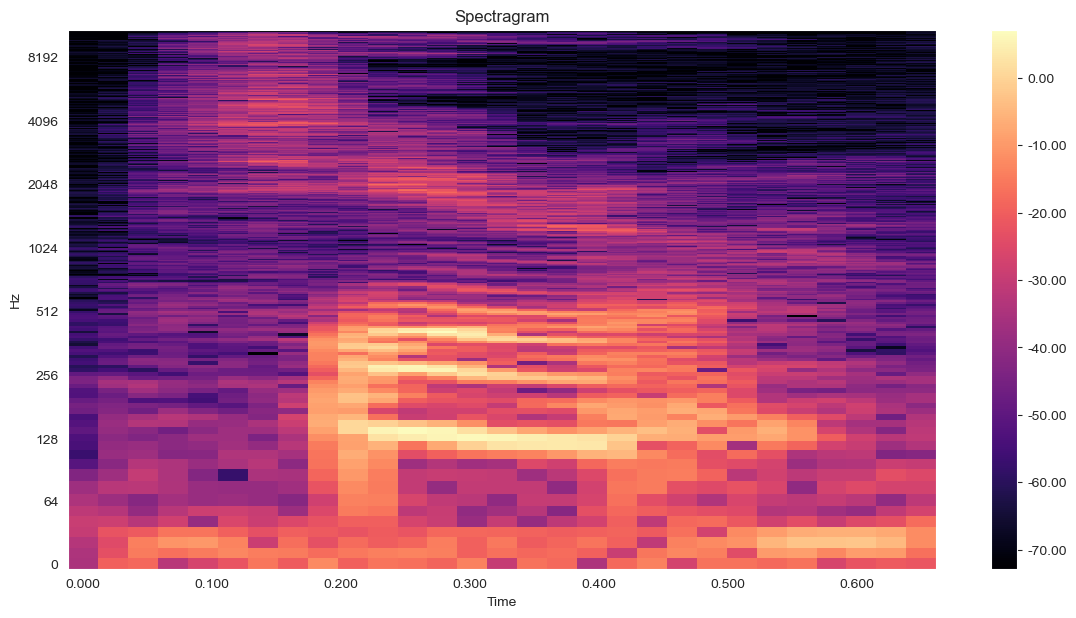

In [8]:
# implementing  
visulizing(df.path[1])

### Data Minapulation

In [9]:
def create_waveplot(data,sr):
    plt.figure(figsize=(14,3))
    plt.title('WavePlot')
    librosa.display.waveshow(data,sr=sr)
    plt.show()

In [10]:
def noise(data,sr):
    noise_amp=.04*np.random.uniform()*np.max(data)
    data+=noise_amp*np.random.normal(size=data.shape[0])
    display(ipd.Audio(data,rate=sr))
    create_waveplot(data,sr)
    return data
def pitch(data,sr,pitch_factor=.9):#Freq
    data=librosa.effects.pitch_shift(data,sr=sr,n_steps=pitch_factor)
    display(ipd.Audio(data,rate=sr))
    create_waveplot(data,sr)
    return data
def stretch(data,sr,rate=.8):#speed 
    data=librosa.effects.time_stretch(data,rate=rate)
    display(ipd.Audio(data,rate=sr))
    create_waveplot(data,sr)  
    return data
def shift (data,sr):
    shift_range=int(np.random.uniform(low=-5,high=5)*1000)
    data=np.roll(data,shift_range)
    display(ipd.Audio(data,rate=sr))
    create_waveplot(data,sr) 
    return data

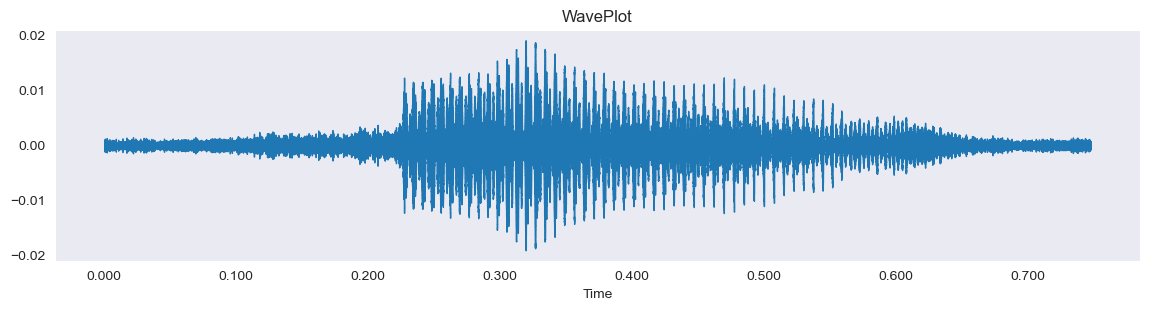

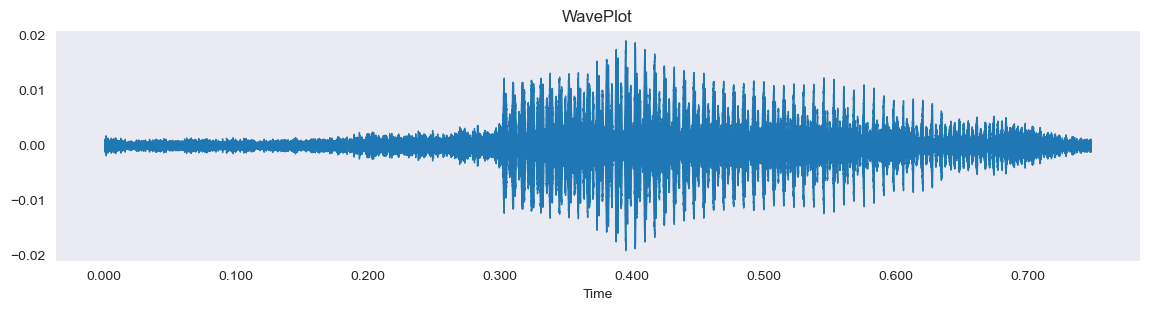

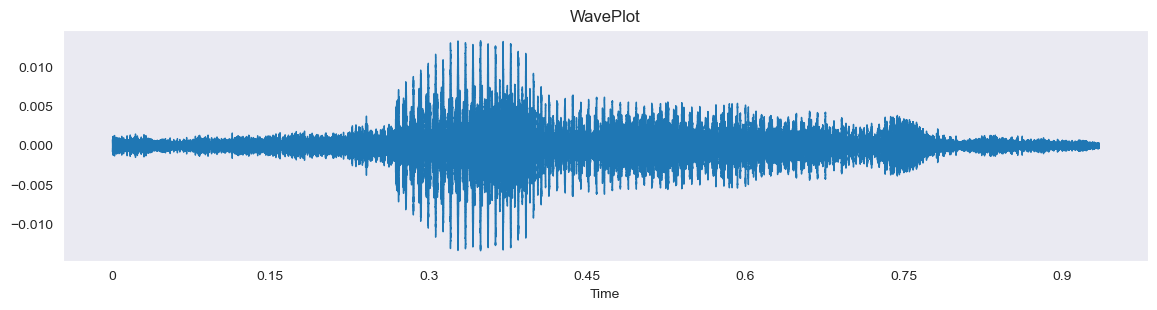

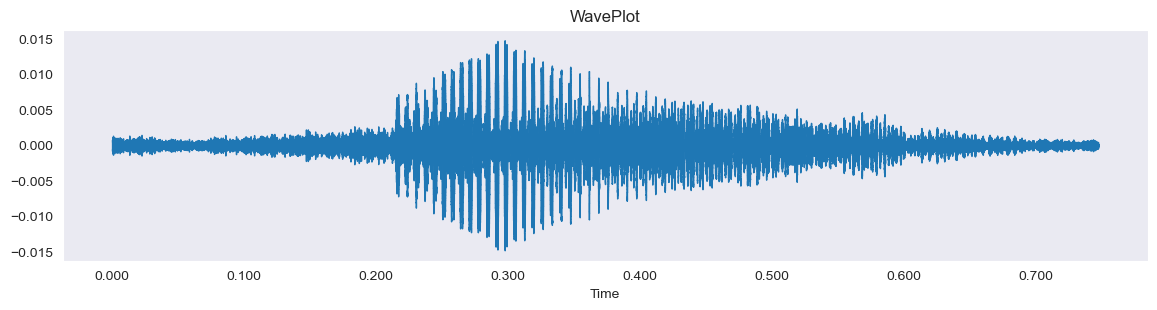

array([ 7.9510524e-04,  4.8022525e-04,  4.3069993e-04, ...,
        6.1829887e-05,  9.1637128e-05, -5.4748038e-05], dtype=float32)

In [11]:
data,sr=librosa.load(df.path[0])
noise(data,sr)
shift(data,sr)
stretch(data,sr)
pitch(data,sr)

### Feature Extraction

In [12]:
def  extract_features(data):
    result=np.array([])
    #ZCR
    zcr=np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
    result=np.hstack((result,zcr))
    #Chroma_stft===> short time forier transformation
    stft=np.abs(librosa.stft(data))
    chroma_stft=np.mean(librosa.feature.chroma_stft(S=stft,sr=sr).T,axis=0)
    result=np.hstack((result,chroma_stft))
    #MFCC
    mfcc=np.mean(librosa.feature.mfcc(y=data,sr=sr).T,axis=0)
    result=np.hstack((result,mfcc))
    #Root Mean Square Value
    rms=np.mean(librosa.feature.rms(y=data).T,axis=0)
    result=np.hstack((result,rms))
    #Mel Spectragram
    mel=np.mean(librosa.feature.melspectrogram(y=data,sr=sr).T,axis=0)
    result=np.hstack((result,mel))
    return result

In [13]:
def get_feature(path):
    data,sr=librosa.load(path)
    #without augmentation
    res1=extract_features(data)
    result=np.array(res1)

    # with noise 
    noise_amp=.04*np.random.uniform()*np.max(data)
    noise_data=data+noise_amp*np.random.normal(size=data.shape[0])
    res2=extract_features(noise_data)
    result=np.vstack((result,res2))

    # Data with stretching and pitching
    #data=librosa.effects.time_stretch(data,rate=.8)
    #shift_range=int(np.random.uniform(low=-5,high=5)*1000)
    #data=np.roll(data,shift_range)
    #res3=extract_features(data)
    #result=np.vstack((result,res3))
    return result

In [14]:
X=[]
Y=[]
for path , number in zip(df.path,df.number):
    features=get_feature(path)
    for i in features:
        X.append(i)
        Y.append(number)

In [15]:
Features=pd.DataFrame(X)
Features['labels']=Y
Features.to_csv('features.csv',index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.103738,0.721555,0.693823,0.567842,0.544618,0.605808,0.505602,0.485598,0.581328,0.615823,...,0.000006,0.000006,0.000008,0.000005,0.000006,0.000006,0.000005,0.000004,2.597673e-07,zero
1,0.134884,0.758011,0.725769,0.596352,0.584362,0.642949,0.525585,0.504173,0.604750,0.636010,...,0.000007,0.000007,0.000009,0.000007,0.000008,0.000007,0.000007,0.000005,1.572300e-06,zero
2,0.085735,0.820589,0.779740,0.674279,0.654344,0.662057,0.550160,0.552474,0.562385,0.601287,...,0.000007,0.000008,0.000007,0.000006,0.000005,0.000006,0.000008,0.000005,4.071220e-07,zero
3,0.179755,0.846966,0.849093,0.768781,0.769514,0.758711,0.662053,0.629397,0.656074,0.699053,...,0.000016,0.000018,0.000017,0.000019,0.000016,0.000015,0.000018,0.000018,1.240873e-05,zero
4,0.118652,0.619559,0.669167,0.626445,0.614516,0.658916,0.599252,0.516389,0.557209,0.638722,...,0.000017,0.000015,0.000010,0.000009,0.000011,0.000014,0.000020,0.000013,1.130365e-06,zero


### Preparing Data

#### Encodering 

In [16]:
X=Features.iloc[:,:-1].values
Y=Features["labels"].values
encoder =OneHotEncoder()
#reshape(-1,1) ==> reshape an array into a two-dimensional array with one column
Y=encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


#### Spliting Data

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=.1, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((54000, 162), (54000, 10), (6000, 162), (6000, 10))

#### Scaling

In [18]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)
x_train.shape,x_test.shape

((54000, 162), (6000, 162))

In [19]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((54000, 162, 1), (54000, 10), (6000, 162, 1), (6000, 10))

### Modeling

In [20]:
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,Dropout,Flatten,Dense
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [21]:
model=Sequential()
model.add(Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu',input_shape=(x_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))

model.add(Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))

model.add(Conv1D(128,kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))
model.add(Dropout(.2))

model.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))

model.add(Flatten())
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(.3))

model.add(Dense(units=10,activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)          

In [22]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
early_stopping=EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True)
history=model.fit(x_train,y_train,batch_size=64,epochs=50,validation_data=(x_test,y_test),callbacks=[early_stopping])

Epoch 1/50


844/844 [==============================] - 26s 29ms/step - loss: 1.0998 - accuracy: 0.5947 - val_loss: 0.6889 - val_accuracy: 0.7418
Epoch 2/50
844/844 [==============================] - 24s 28ms/step - loss: 0.5470 - accuracy: 0.8016 - val_loss: 0.9779 - val_accuracy: 0.7367
Epoch 3/50
844/844 [==============================] - 25s 29ms/step - loss: 0.4132 - accuracy: 0.8533 - val_loss: 0.8778 - val_accuracy: 0.7668
Epoch 4/50
844/844 [==============================] - 24s 29ms/step - loss: 0.3482 - accuracy: 0.8785 - val_loss: 1.0065 - val_accuracy: 0.7733
Epoch 5/50
844/844 [==============================] - 24s 29ms/step - loss: 0.2928 - accuracy: 0.8967 - val_loss: 0.5538 - val_accuracy: 0.8333
Epoch 6/50
844/844 [==============================] - 25s 30ms/step - loss: 0.2576 - accuracy: 0.9091 - val_loss: 0.4084 - val_accuracy: 0.8618
Epoch 7/50
844/844 [==============================] - 25s 30ms/step - loss: 0.2415 - accuracy: 0.9175 - val_loss: 0.4478 - val_accurac

In [24]:
# Calculate the average training & validation accuracy
avg_train_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
avg_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print("Average Training Accuracy:", avg_train_accuracy)
print("Average Validation Accuracy:", avg_val_accuracy)

Average Training Accuracy: 0.946946667432785
Average Validation Accuracy: 0.8841966664791108


188/188 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.9258
Accuracy of our model on test data :  92.58333444595337 %


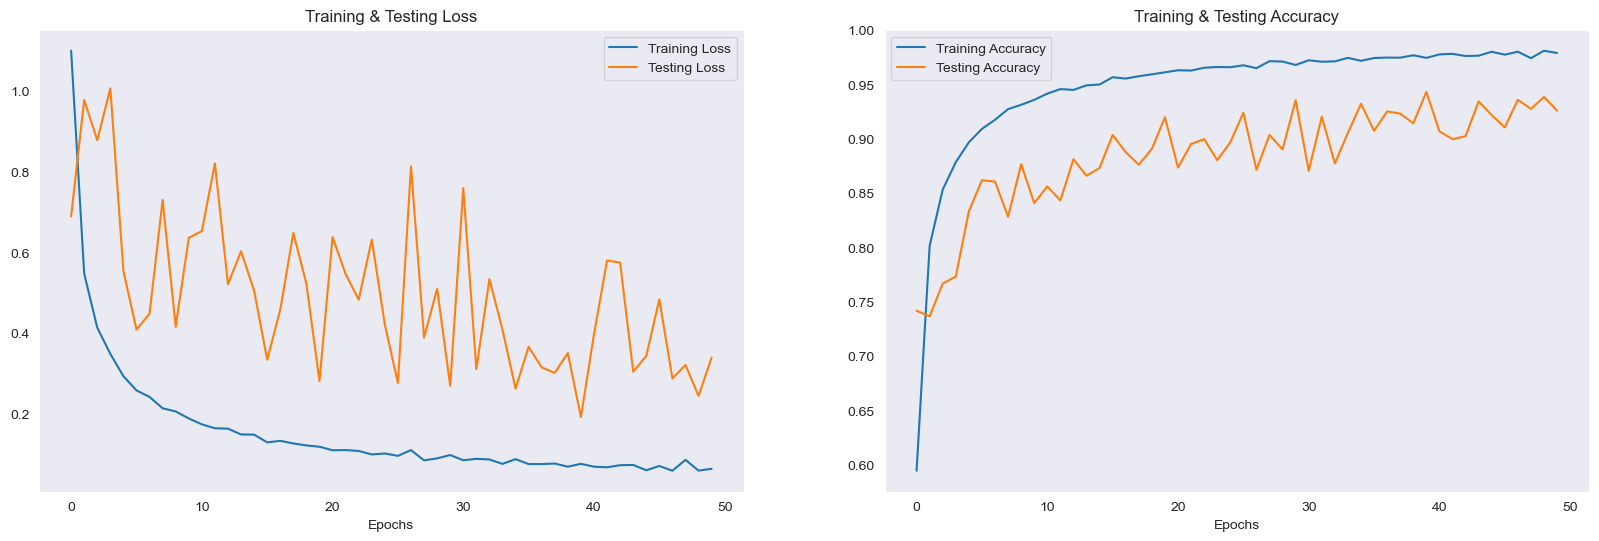

In [25]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

#### Model 2 

In [26]:
model_2=Sequential()
# Add first layer with 100 neurons to the sequental object
model_2.add(Dense(100,input_shape=(x_train.shape[1],),activation='relu'))
# Add second layer with 200 neurons to the sequental object
model_2.add(Dense(100,activation='relu'))
# Add third later with 100 neurons to the sequental object
model_2.add(Dense(100,activation='relu'))

# Output layer With 10 neurons as it has 10 classes
model_2.add(Dense(10,activation='softmax'))

In [27]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               16300     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 37510 (146.52 KB)
Trainable params: 37510 (146.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# Compile the model
model_2.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [29]:
history_2=model_2.fit(x_train,y_train,batch_size=32,epochs=50,validation_data=(x_test,y_test),callbacks=[early_stopping])

Epoch 1/50
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3637 - accuracy: 0.8773 - val_loss: 0.1840 - val_accuracy: 0.9388
Epoch 2/50
1688/1688 [==============================] - 2s 1ms/step - loss: 0.1437 - accuracy: 0.9525 - val_loss: 0.1176 - val_accuracy: 0.9595
Epoch 3/50
1688/1688 [==============================] - 2s 1ms/step - loss: 0.1084 - accuracy: 0.9654 - val_loss: 0.1334 - val_accuracy: 0.9560
Epoch 4/50
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0760 - accuracy: 0.9751 - val_loss: 0.1089 - val_accuracy: 0.9622
Epoch 5/50
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0720 - accuracy: 0.9779 - val_loss: 0.0840 - val_accuracy: 0.9702
Epoch 6/50
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0562 - accuracy: 0.9809 - val_loss: 0.0791 - val_accuracy: 0.9715
Epoch 7/50
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0504 - accuracy: 0.9831 - val_loss: 0.0803 - val_accuracy:

In [30]:
# Calculate the average training & validation accuracy
avg_train_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
avg_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
print("Average Training Accuracy:", avg_train_accuracy)
print("Average Validation Accuracy:", avg_val_accuracy)

Average Training Accuracy: 0.946946667432785
Average Validation Accuracy: 0.8841966664791108


188/188 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.9258
Accuracy of our model on test data :  92.58333444595337 %


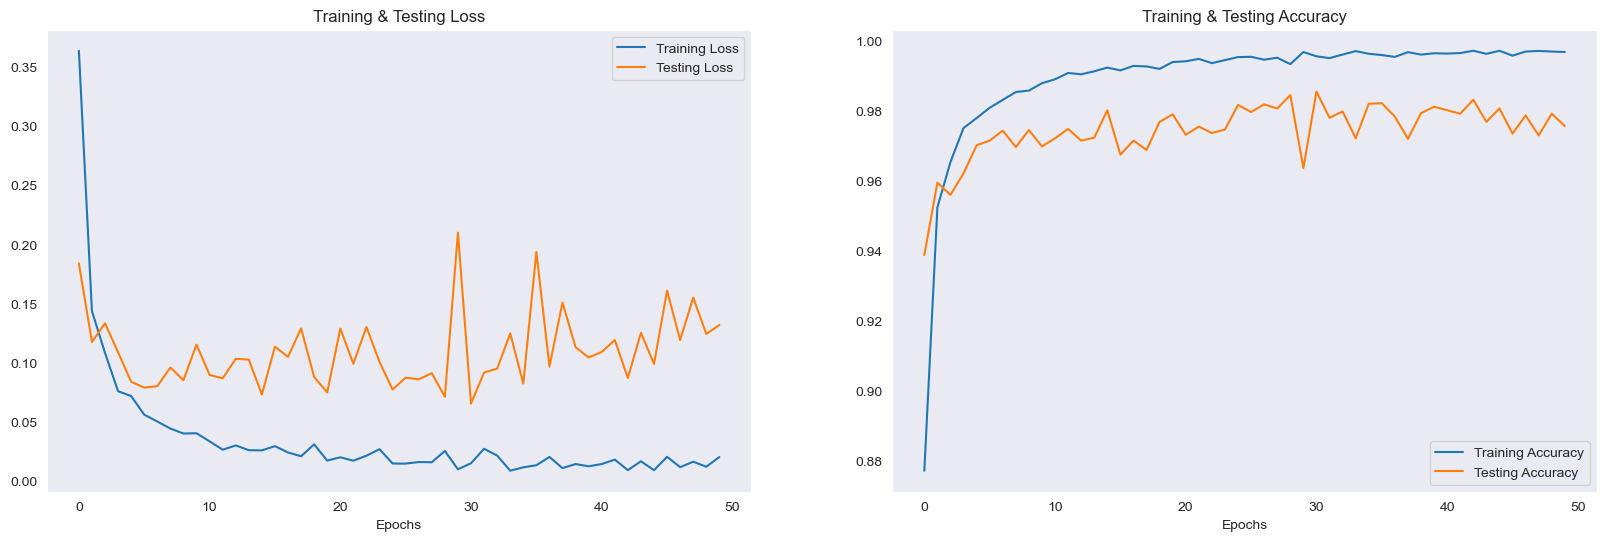

In [31]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history_2.history['accuracy']
train_loss = history_2.history['loss']
test_acc = history_2.history['val_accuracy']
test_loss = history_2.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()